In [1]:
import sys
# sys.path.insert(0, '/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP')
import time
import random
import csv
import numpy as np

import scipy.io
from scipy.io import loadmat

import torch
import pickle

from tqdm import tqdm
from tqdm import notebook

import matplotlib
import matplotlib.pyplot as plt

import importlib
import utils
importlib.reload(utils)
TORCH_DTYPE = torch.float64 #NB: Basically all of the matrices in Spatial_GP have 1.e-7 added to the diagonal, to be changed if we want to use float64
# Set the default dtype to float64
torch.set_default_dtype(TORCH_DTYPE)



# with open('data/processed_data.pkl', 'wb') as f:
#     pickle.save(f)

# To compare with samuale use:
# save_pickle('pietro_data', **{'K_pietro':K, 'K_tilde_pietro':K_tilde})    

Using device: cuda:0 (from utils.py)
Using device: cuda:0 (from utils.py)


## Parameters of the training

In [2]:
rand_xtilde = False # If True, xtilde (inducing points) are chosen randomly, if False, xtilde is chosen from the first ntilde images
noise       = False # If True, noise is added to xtilde (used to avoid inducing points being too close to each other in their space)
rescale     = False # If True, X is rescaled between -1 and 1
cellid      = 1   # Choose cell
ntilde      = 2000  # Number of xtilde
kernfun     = utils.acosker_samu # Choose kernel function

Nmstep  = 6
Nestep  = 8
Maxiter = 10

## Import the dataset and preprocess


In [3]:
# Import the data

# Set the device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.set_default_dtype(TORCH_DTYPE)
torch.set_default_device(device)
print(f'Device is: {device}')

# Open the .pkl dataset file for reading in binary mode (rb)
with open('/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP/Data/data2_41mixed_tr28.pkl', 'rb') as file:
    # Load the data from the file
    loaded_data = pickle.load(file)
    # loaded_data is a Dataset object from module Data with attributes "images_train, _val, _test" as well as responses

X_train = torch.tensor(loaded_data.images_train).to(device, dtype=TORCH_DTYPE) #shape (2910,108,108,1) where 108 is the number of pixels. 2910 is the amount of training data
X_val   = torch.tensor(loaded_data.images_val).to(device, dtype=TORCH_DTYPE)
X_test  = torch.tensor(loaded_data.images_test).to(device, dtype=TORCH_DTYPE) # shape (30,108,108,1) # nimages, npx, npx

R_train = torch.tensor(loaded_data.responses_train).to(device, dtype=TORCH_DTYPE) #shape (2910,41) 2910 is the amount of training data, 41 is the number of cells
R_val   = torch.tensor(loaded_data.responses_val).to(device, dtype=TORCH_DTYPE)
R_test  = torch.tensor(loaded_data.responses_test).to(device, dtype=TORCH_DTYPE) # shape (30,30,42) 30 repetitions, 30 images, 42 cells

# Concatenate Xtrain and Xval if not using validation set 
X = torch.cat( (X_train, X_val), axis=0,) #shape (3160,108,108,1)
R = torch.cat( (R_train, R_val), axis=0,)
# X = X_train
# R = R_train

# Rescale X to be between -1 and 1
if rescale == True:
    X = (X - X.min()) / (X.max() - X.min()) * 2 - 1

# Choose a cell
r = R[:,cellid] # shape (nt,) where nt is the number of trials

# Reshape images to 1D vector
n_px_side = X.shape[1] # 108   
X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2])) 
# If X_val is being used, reshape it
# X_val = torch.reshape(X_val, ( X_val.shape[0], X_val.shape[1]*X_val.shape[2])) # shape (n x val, 11664)=(nt, nx)

if rand_xtilde == True:
    torch.manual_seed(2024)
    indices = torch.randint(0, X.shape[0], (ntilde,))
else:
    indices = torch.arange(0,ntilde, dtype=torch.int64)
if noise == True:
    xtilde = X[indices,:] + 1e-7*torch.rand(X[indices,:].shape)*2 - 1.e-7
else:
    xtilde = X[indices,:]


Device is: cuda:0


In [4]:
# If one wants to compare the hyperparemeters set in Samuele's code:
logsigma_0 = torch.tensor(0) # Samuele's code set the log of sigma

logbetaexpr = torch.tensor(4.65)
# logbetaexpr = fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5

logrhoexpr = torch.tensor(4.3)
# logrhoexpr  = fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 

Amp = torch.tensor(1.0) # Samuele's code set Amp to 1 does not learn it (absent in the code)

# test
theta = {'sigma_0': torch.exp(logsigma_0), 'eps_0x':torch.tensor(0.), 'eps_0y':torch.tensor(0.), '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr, 'Amp': Amp }
# theta = {'sigma_0': torch.tensor(1.e-6), 'eps_0x':torch.tensor(0.0), 'eps_0y':torch.tensor(0.0), '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr, 'Amp': Amp }

for key, value in theta.items():
    #test
    # to exclude Amp from the optimization
    # if key == 'Amp':
        # continue
    # if key == 'sigma_0':
        # continue
    # if key == '-log2rho2' or key == '-2log2beta':
        # continue
    # if key == 'eps_0x' or key == 'eps_0y':
    #    continue 
    #end test
    theta[key] = value.requires_grad_()

hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True, **theta)


# A        = torch.tensor(0.007)
A        = torch.tensor(0.007)
logA     = torch.log(A)
f_params = {'logA': logA, 'lambda0':torch.tensor(0.31)}
# f_params = {'A': torch.tensor(0.0017), 'lambda0':torch.tensor(0.3697)}
# f_params = {'A': torch.tensor(-0.0807), 'lambda0': torch.tensor(0.3762)}
for key, value in f_params.items():
    f_params[key] = value.requires_grad_()

args = {
        'ntilde':  ntilde,
        'Maxiter': Maxiter,
        'Nmstep':  Nmstep,
        'Nestep':  Nestep,
        'kernfun': kernfun,
        'n_px_side': n_px_side,
        'display_prog':  False,
        'hyperparams_tuple': hyperparams_tuple,
        'f_params': f_params,
        'xtilde': xtilde,

        'm': torch.zeros( (ntilde) )
        # 'm': torch.ones( (ntilde) )
    }


updated sigma_0 to 1.0
updated eps_0x to 0.0
updated eps_0y to 0.0
updated -2log2beta to 4.65
updated -log2rho2 to 4.3
updated Amp to 1.0
 Before overloading
 Hyperparameters have been SET as  : beta = 0.05856070, rho = 0.02928035
 Samuele hyperparameters           : logbetasam = 4.9822, logrhosam = 7.0617

 After overloading
 Dict of learnable hyperparameters : sigma_0 = 1.00000000, eps_0x = 0.00000000, eps_0y = 0.00000000, -2log2beta = 4.65000000, -log2rho2 = 4.30000000, Amp = 1.00000000
 Hyperparameters from the logexpr  : beta = 0.04889172, rho = 0.08236674
 Samuele hyperparameters           : logbetasam = 5.3431, logrhosam = 4.9931


In [5]:
theta_fit, f_params_fit, m_b_fit, V_b_fit, C_fit, mask_fit, K_tilde_b_fit, K_tilde_inv_b_fit, B, values_track_fit = utils.varGP(X, r, **args)

*Iteration*: 0
 1861.6900 = logmarginal in m-step
 1841.6105 = logmarginal in m-step
 1841.4366 = logmarginal in m-step
 1841.4366 = logmarginal in m-step
 1831.8426 = logmarginal in m-step
 1831.8095 = logmarginal in m-step
 1831.8095 = logmarginal in m-step
 1830.1755 = logmarginal in m-step
 1830.1701 = logmarginal in m-step
*Iteration*: 1
 1752.4942 = logmarginal in m-step
 1733.7895 = logmarginal in m-step
 1733.6226 = logmarginal in m-step
 1733.6226 = logmarginal in m-step
 1724.5124 = logmarginal in m-step
 1724.4772 = logmarginal in m-step
 1724.4772 = logmarginal in m-step
 1722.6471 = logmarginal in m-step
 1722.6439 = logmarginal in m-step
*Iteration*: 2
 1675.9922 = logmarginal in m-step
 1662.3157 = logmarginal in m-step
 1662.1893 = logmarginal in m-step
 1662.1893 = logmarginal in m-step
 1655.6480 = logmarginal in m-step
 1655.6275 = logmarginal in m-step
 1655.6275 = logmarginal in m-step
 1654.8906 = logmarginal in m-step
 1654.8837 = logmarginal in m-step
*Iteration

In [6]:
# Save the model. All of the matrices are projected in the eigenspace of big eigenvalues of K_tilde
model_b = {
    'theta': theta_fit,
    'f_params': f_params_fit,
    'm_b': m_b_fit,
    'V_b': V_b_fit,
    'C'  : C_fit,
    'mask': mask_fit,
    'K_tilde_inv_b': K_tilde_inv_b_fit,
    'K_tilde_b': K_tilde_b_fit,
    'B': B,
    'cellid' : cellid,
    'ntilde' : ntilde,
    'Maxiter': Maxiter,
    'Nmstep' : Nmstep,
    'Nestep' : Nestep,
    'kernfun': kernfun,
    'values_track': values_track_fit,
}

# save_pickle('pietro_model', **model)


Using device: cuda:0 (from utils.py)
f_params: {'logA': tensor(-3.7564, device='cuda:0', requires_grad=True), 'lambda0': tensor(0.2236, device='cuda:0', requires_grad=True)}
 sigma_0     :   1.0030
 eps_0x      :   0.0726
 eps_0y      :  -0.0806
 -2log2beta  :   4.6387 --> beta:   0.0492
 -log2rho2   :   4.3228 --> rho :   0.0814
 Amp         :   1.0131


 Pietro's model: R2 = 0.97 ± 0.01 Cell: 1 Maxiter = 10, Nestep = 8, nMstep = 6 



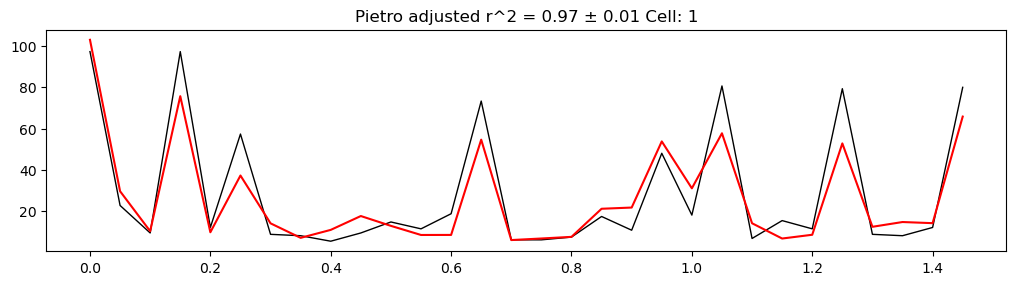

In [8]:
importlib.reload(utils)
torch.set_grad_enabled(False)

# To compare to samuele I have to kep the aplitude of C fixed to 1, he does not have it
# theta['Amp'] = 1.0

print(f'f_params: {f_params}')
utils.print_hyp(model_b['theta'])

# Predict and test
R_test_cell, R_pred_cell, r2, sigma_r2 = utils.test(X_test, R_test, xtilde, **model_b )


R_test_cell = R_test_cell.cpu().numpy()
R_pred_cell = R_pred_cell.cpu().numpy()
r2          = r2.cpu().numpy()
sigma_r2    = sigma_r2.cpu().numpy()

# Plot results after putting on cpu, numpy.
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(5, 5,
            left=0.1, right=0.9, bottom=0.1, top=0.9,
            wspace=0.3, hspace=0.7)
dt = 0.05
time_values = dt * np.arange( len(R_pred_cell) )
ax = fig.add_subplot(gs[3:, :])
ax.plot(time_values, np.mean(R_test_cell, axis=0) / 0.05, 'k', linewidth=1)

ax.plot(time_values, R_pred_cell / 0.05, color='red', label='GP')
# ax.errorbar(time_values, R_predicted / 0.05, yerr=np.sqrt(sigma2_f[:,0].cpu()) / 0.05, color='red')
# ax.legend(['data', 'GP'], loc='upper right', fontsize=14)
txt = f'Pietro adjusted r^2 = {r2:.2f} ± {sigma_r2:.2f} Cell: {cellid}'
ax.set_title(f'{txt}')
# ax.set_ylabel('Firing rate (Hz)')
plt.show()
plt.close()


a=1